In [11]:
################################
# Basic layout of the notebook #
################################
#
# 1. Load all prerequisites
# 2. Create a noise generator which outputs noise parameterized by some vars.
# 3. Create an adversary which creates adversarial images according to this noise generator.
# 4. Write a loop to display a few images (real image, regular noise, adversarial)
#
# (Unused)
# 4a. Write a loop to display a few images (real image, regular noise, adv 1, 3, 10 steps.)
# 4b. Write a function to display the averages (real image, regular noise, adv 1, 3, 10 steps.)

#########################################
# Basic layout of the problem statement #
#########################################
#
# 1. You have an image x.
# 2. You can modifiy x by adding adversarial noise to x.
# 2a. There are restrictions on the parameterization of the adversarial noise
# 2b. There are restrictions on the scale of the adversarial noise (?)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as trn
import skimage as sk

%matplotlib inline

In [4]:
test_transform = trn.Compose([trn.Resize(256), trn.CenterCrop(224), trn.ToTensor()])

mean = torch.FloatTensor(np.array([0.485, 0.456, 0.406]).reshape(1,3,1,1)).cuda()
std = torch.FloatTensor(np.array([0.229, 0.224, 0.225]).reshape(1,3,1,1)).cuda()

test_data = dset.ImageFolder('/home/oliver/git/data/imagenette2/val/', transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True,
                                          num_workers=1, pin_memory=True)

In [5]:
def remove_module(state_dict):
    d = {}
    for key in state_dict:
        d[key[7:]] = state_dict[key]
    return d

net = models.resnet50()
'''
net.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth',
                                       model_dir='/home/hendrycks/datasets/models'))
'''
session = torch.load('/home/oliver/git/models/deepaugment_and_augmix.pth.tar', map_location=torch.device('cuda'))
state_dict = remove_module(session['state_dict'])
net.load_state_dict(state_dict)
#'''
net.eval()
net.cuda()
cudnn.benchmark = True  # fire on all cylinders

In [6]:
to_np = lambda z: z.to('cpu').detach().numpy()

In [27]:
def caustic_noise_creator(vars, bsize):
    '''
    Creates some noise based on some variable. 
    Creation of noise should be batched and enable gradients 
    to flow through it.
    '''
    time, size = vars
    size = 256*size
    
    y_axis = torch.arange(0, 256).reshape(256, 1, 1).repeat(1, 256, 1)
    x_axis = torch.arange(0, 256).reshape(1, 256, 1).repeat(256, 1, 1)
    grid = torch.cat((y_axis, x_axis), axis=2).cuda()
    grid = grid + torch.rand((256, 256, 2), device='cuda')
    
    grid = grid / size
    p = (grid - torch.floor(grid)) * 6.28318530718 - 250
    i = p.clone()
    c = torch.ones((256, 256), device="cuda")
    inten = 0.005
    
    for n in range(5):
        t = time * (1.0 - (3.5 / (n+1)))
        
        temp1 = torch.cos(t - i[:, :, 0])
        temp2 = torch.cos(t + i[:, :, 0])
        temp3 = torch.sin(t - i[:, :, 1])
        temp4 = torch.sin(t + i[:, :, 1])
        i = p + torch.stack([temp1 + temp4, temp2 + temp3], dim=2)
        
        temp5 = p[:,:,0] / (torch.sin(t + i[:, :, 0])/inten)
        temp6 = p[:,:,1] / (torch.cos(t + i[:, :, 1])/inten)
        length = torch.sqrt(temp5**2 + temp6**2)
        c += 1.0/length
    
    c /= 5.0
    c = 1.17 - c ** 1.4
    color = torch.clip(torch.abs(c) ** 8.0, 0, 1) 
    noise = torch.stack([color, color, color], dim=0).unsqueeze(0)
    return noise

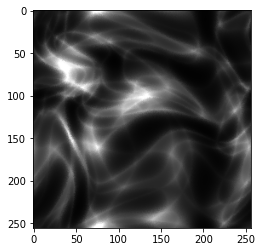

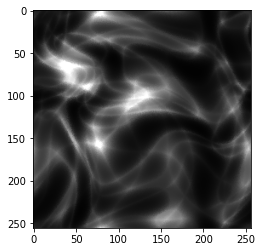

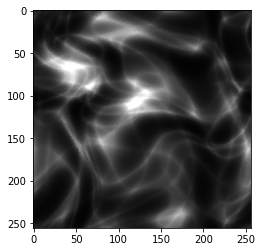

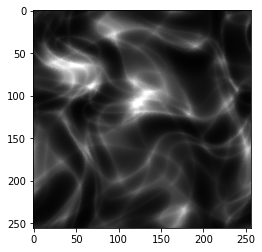

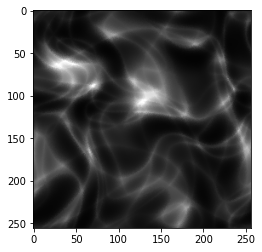

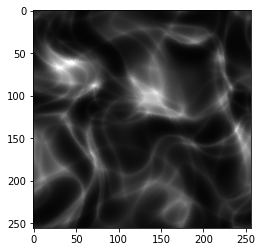

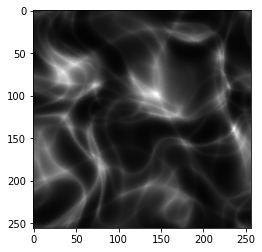

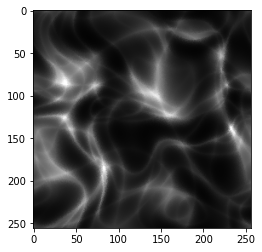

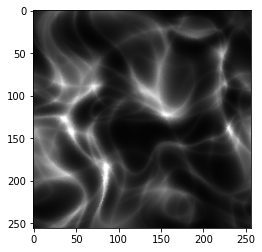

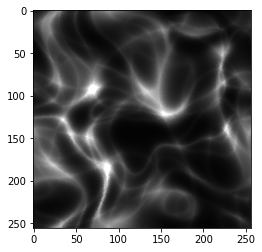

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt

vars = (1.25, 1)

for i in range(10):
    noise = caustic_noise_creator((1 + 0.05 * i, 1), 1).cpu().numpy()[0]
    noise = noise.transpose((1, 2, 0))
    plt.imshow(noise)
    plt.figure()

In [52]:
class CausticNoiseAdversary(nn.Module):
    def __init__(self, eps=0.05, scale=1, num_steps=10, step_size=0.01):
        super().__init__()
        self.eps = eps
        self.scale = scale
        self.num_steps = num_steps
        self.step_size = step_size

    def forward(self, model, bx, by, x_max):
        """
        :param model: the classifier's forward method
        :param bx: batch of images
        :param by: true labels
        :return: perturbed batch of images
        """
        bsize = bx.size(0)
        
        # create initial variables
        caustic_noise_vars = [torch.tensor(1.25, requires_grad=True, device="cuda"), torch.tensor(1, requires_grad=True, device="cuda", dtype=torch.float32)]
        
        # create initial images
        adv_bx = bx.detach()
        caustic_noise = caustic_noise_creator(caustic_noise_vars, bsize)[:,:,16:-16,16:-16]
        original = caustic_noise.clone().detach().data

        # begin optimizing the inner loop
        opt = optim.Adam(caustic_noise_vars, lr=0.1)

        #'''
        for i in range(self.num_steps):
            opt.zero_grad()

            with torch.enable_grad():
                caustic_noise = caustic_noise_creator(caustic_noise_vars, bsize)[:,:,16:-16,16:-16]
                logits = model(((adv_bx + self.scale * caustic_noise)/(x_max + self.scale) - mean)/std)
                loss = -F.cross_entropy(logits, by, reduction='sum')
            
            loss.backward(retain_graph=True)
            opt.step()
            
            # clamp variables
            caustic_noise_vars[0].detach()
            caustic_noise_vars[0].clamp(0.5, 2.0)
            caustic_noise_vars[0].requires_grad_()
            
            caustic_noise_vars[1].detach()
            caustic_noise_vars[1].clamp(0.75, 1.25)
            caustic_noise_vars[1].requires_grad_()
        #'''
        caustic_noise = caustic_noise_creator(caustic_noise_vars, bsize)[:,:,16:-16,16:-16]
        return caustic_noise, original

In [53]:
scale = 0.05
eps = 0.05
adv = CausticNoiseAdversary(eps, scale)


Clean Image
Loss: 0.007427577
Right Prediction


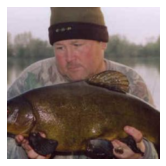


Initial Template
Loss: 0.006988013
Right Prediction


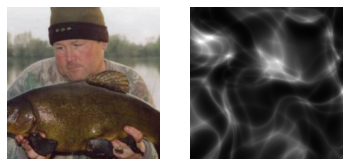


Adversarial Template
Loss: 0.007986044
Right Prediction


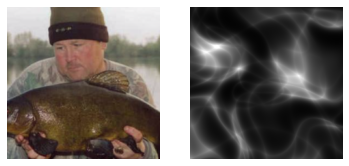


Clean Image
Loss: 20.074383
Wrong Prediction


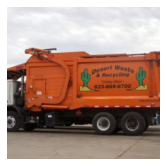


Initial Template
Loss: 20.209892
Wrong Prediction


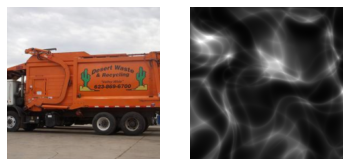


Adversarial Template
Loss: 19.916763
Wrong Prediction


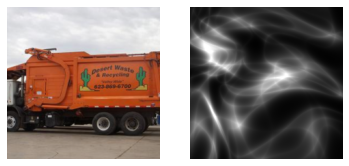


Clean Image
Loss: 13.340941
Wrong Prediction


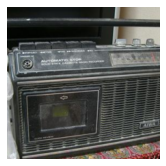


Initial Template
Loss: 13.565134
Wrong Prediction


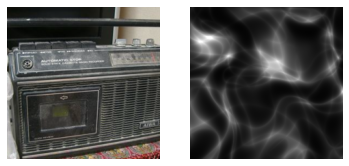


Adversarial Template
Loss: 13.438375
Wrong Prediction


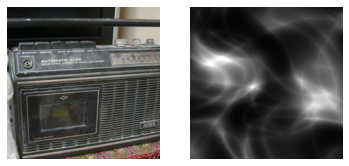

In [54]:
for i, (x, label) in enumerate(test_loader):
    if i < 3:
    
        print('\nClean Image')
        target = torch.LongTensor([label]).cuda()

        x = x.cuda()
        x_max, _ = torch.max(x.view(x.size(0), 3, -1), -1)
        x_max = x_max.view(-1, 3, 1, 1)

        logits = net((x - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1) # induced for comparable size
        plt.imshow(to_np(x).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()

        print('\nInitial Template')

        adv_template, original_template = adv(net, x, target, x_max)
        
        logits = net(((x + scale * original_template)/(x_max + scale) - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1)
        plt.imshow(to_np((x + scale * original_template)/(x_max + scale)).squeeze().transpose((1,2,0)))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.imshow(to_np(original_template).squeeze().transpose((1,2,0)), cmap='gray')
        plt.axis('off')
        plt.show()
        
        print('\nAdversarial Template')
        
        logits = net(((x + scale * adv_template)/(x_max + scale) - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])

        plt.subplot(1,2,1)
        plt.imshow(to_np((x + scale * adv_template)/(x_max + scale)).squeeze().transpose((1,2,0)))
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(to_np(adv_template).squeeze().transpose((1,2,0)), cmap='gray')
        plt.axis('off')
        plt.show()
        
    else:
        break